In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import similaritymeasures
from shapely.geometry import Polygon
from scipy.spatial import distance
import matplotlib.pyplot as plt
from nltk.metrics.distance import jaccard_distance
from nltk.metrics.distance import edit_distance
from nltk.util import ngrams
from sys import getsizeof
import shape_utility as su

In [2]:
geoshape = gpd.read_file("map.shp")

In [3]:
df = pd.DataFrame()
for name in geoshape:
    df[name] = []
    
# select items in the shape file which contains a polygon
j = 0
#for i in range(len(geoshape)):
for i in range(50):
    if type(geoshape.iloc[i]["geometry"]) == Polygon:
        df.loc[j] = geoshape.iloc[i]
        j += 1

# get the space where the largest polygon convers
canvas = su.get_canvas_from_polygons(df["geometry"])

# larger edge of the canvas sides
min_length = min((canvas["x1"] - canvas["x0"]), (canvas['y1'] - canvas['y0']))

# calculate the hausdorrff distance and fretcher distance between first polygon and the rest as the test metrics
# df holding the polygon data for measuring
df['hausdorff_distance'] = [0] * len(df)
df['fretcher_distance'] = [0] * len(df)
target = df.loc[0]['geometry']
for i in range(len(df)):
    if i != 0:
        polygon = df.loc[i]['geometry']
        df.loc[i, ['hausdorff_distance']] = su.get_hausdorff_distance(target, polygon)
        df.loc[i, ['fretcher_distance']] = su.get_fretcher_distance(target, polygon)
df[["hausdorff_distance", 'fretcher_distance']].head()

,hausdorff_distance,fretcher_distance
0,0.000000,0.000000
1,0.601963,0.814756
2,0.310788,0.310789
3,0.263996,0.266962
4,0.377719,0.538974


In [4]:
# calculate the grid sketch hash. includes line-by-line and z-wrap two modes
df2 = pd.DataFrame({"Hash Type": ["line-by-line", "Z-wrap"]})
words = [4, 8, 16, 32]
scales = [50, 100, 200]
for scale in scales:
    interval = min_length / scale
    df3 = pd.DataFrame()
    for i in (range(len(df))):
        polygon = df.loc[i]['geometry']
        df3.loc[i, ['line']] = su.grid_to_string(polygon, interval, 1)
        df3.loc[i, ['z']] = su.grid_to_string(polygon, interval, 2)
    for word in words:
        df4 = pd.DataFrame()
        for i in (range(len(df))):
            df4.loc[i, ['line-jd']] = jaccard_distance(set(ngrams(df3.loc[0]['line'], word)), set(ngrams(df3.loc[i]['line'], word)))
            df4.loc[i, ['z-jd']] = jaccard_distance(set(ngrams(df3.loc[0]['z'], word)), set(ngrams(df3.loc[i]['z'], word)))
        df2.loc[0, ["scale=" + str(scale) + " shingle=" + str(word)]] = df4['line-jd'].corr(df['hausdorff_distance'], method='pearson')
        df2.loc[1, ["scale=" + str(scale) + " shingle=" + str(word)]] = df4['z-jd'].corr(df['hausdorff_distance'], method='pearson')
        df4[['line-jd', 'z-jd']].head()
# get the correlation between jaccard distance and grid hash
print(df2)
        

      Hash Type  scale=50 shingle=4  scale=50 shingle=8  scale=50 shingle=16  \
0  line-by-line             0.40329            0.443589             0.418173   
1        Z-wrap             0.29820            0.555968             0.551137   

   scale=50 shingle=32  scale=100 shingle=4  scale=100 shingle=8  \
0             0.382466             0.165509             0.374195   
1             0.443899             0.231713             0.451037   

   scale=100 shingle=16  scale=100 shingle=32  scale=200 shingle=4  \
0              0.527402              0.469199             0.039656   
1              0.524532              0.443931             0.034386   

   scale=200 shingle=8  scale=200 shingle=16  scale=200 shingle=32  
0             0.340968              0.411269              0.436201  
1             0.393230              0.532956              0.476629  


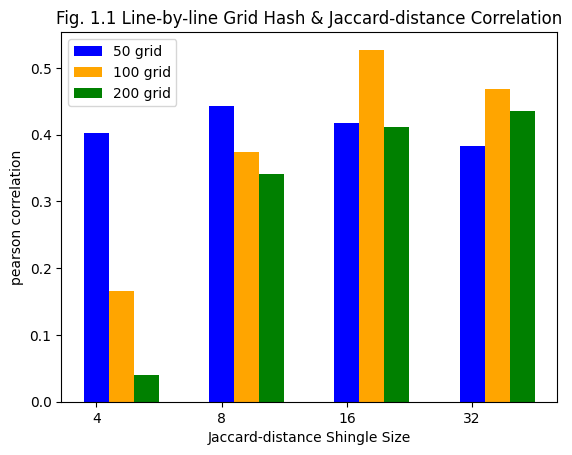

In [5]:
n_groups = 4
index = np.arange(n_groups)
bar_width = 0.2

fig, axs = plt.subplots()
plt.title("Fig. 1.1 Line-by-line Grid Hash & Jaccard-distance Correlation")
axs.set_ylabel("pearson correlation")
axs.bar(index, np.array(df2.iloc[0, 1:5]), bar_width, label="50 grid", color="blue")
axs.bar(index+bar_width, np.array(df2.iloc[0, 5:9]), bar_width, label="100 grid", color="orange")
axs.bar(index+bar_width*2, np.array(df2.iloc[0, 9:13]), bar_width, label="200 grid", color="g")
axs.set_xticks(ticks=[0, 1, 2, 3], labels=["4", "8", "16", "32"])
axs.set_xlabel("Jaccard-distance Shingle Size")
plt.legend()
plt.show()


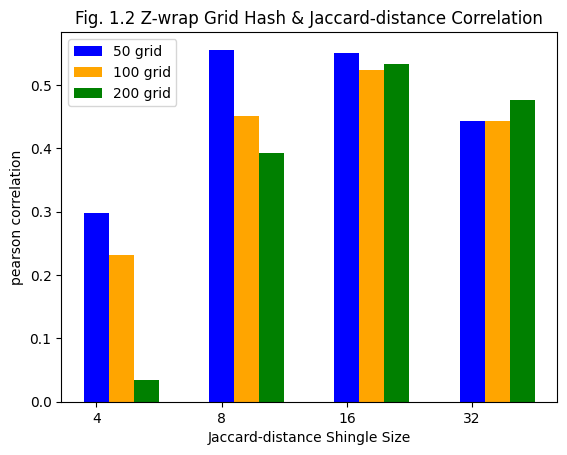

In [6]:
fig, axs = plt.subplots()
plt.title("Fig. 1.2 Z-wrap Grid Hash & Jaccard-distance Correlation")
axs.set_ylabel("pearson correlation")
axs.bar(index, np.array(df2.iloc[1, 1:5]), bar_width, label="50 grid", color="blue")
axs.bar(index+bar_width, np.array(df2.iloc[1, 5:9]), bar_width, label="100 grid", color="orange")
axs.bar(index+bar_width*2, np.array(df2.iloc[1, 9:13]), bar_width, label="200 grid", color="g")
axs.set_xticks(ticks=[0, 1, 2, 3], labels=["4", "8", "16", "32"])
axs.set_xlabel("Jaccard-distance Shingle Size")
plt.legend()
plt.show()

In [7]:
df['LINEGRIDHASH'] = [''] * len(df)
df['ZCURVEHASH'] = [''] * len(df)
for i in range(len(df)):
    polygon = df.loc[i]['geometry']
    df.loc[i, ['LINEGRIDHASH']] = su.grid_to_string(polygon, min_length / 100, 1)
    df.loc[i, ['ZCURVEHASH']] = su.grid_to_string(polygon, min_length / 50, 2)
    
df['LINEGRIDJD'] = [0] * len(df)
df['ZCURVEJD'] = [0] * len(df)
for i in range(len(df)):
    if i != 0:
        df.loc[i, ['LINEGRIDJD']] = jaccard_distance(set(ngrams(df.loc[0]['LINEGRIDHASH'], 16)), set(ngrams(df.loc[i]['LINEGRIDHASH'], 16)))
        df.loc[i, ['ZCURVEJD']] = jaccard_distance(set(ngrams(df.loc[0]['ZCURVEHASH'], 16)), set(ngrams(df.loc[i]['ZCURVEHASH'], 16)))

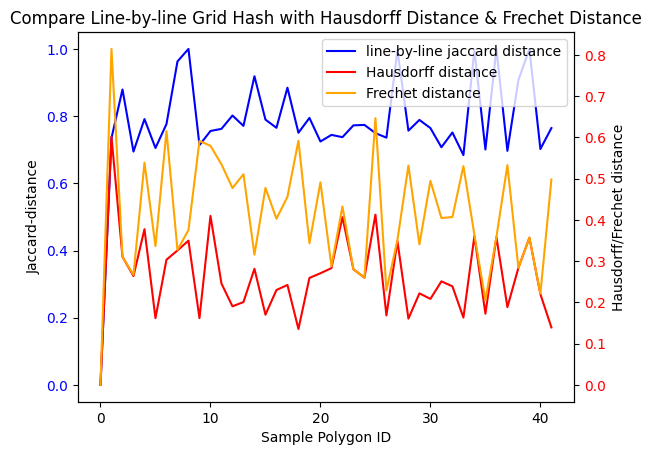

In [9]:
fig, axs = plt.subplots()

axs.set_title('Compare Line-by-line Grid Hash with Hausdorff Distance & Frechet Distance')
line1 = axs.plot(df['LINEGRIDJD'], color='blue', label='line-by-line jaccard distance')
axs.tick_params(axis='y', labelcolor='blue')
axs.set_ylabel("Jaccard-distance")
axs2 = axs.twinx()
line2 = axs2.plot(df['hausdorff_distance'], color='red', label='Hausdorff distance')
line3 = axs2.plot(df['fretcher_distance'], color='orange', label='Frechet distance')
axs2.tick_params(axis='y', labelcolor='red')
axs2.set_ylabel("Hausdorff/Frechet distance")
axs.set_xlabel("Sample Polygon ID")
lines = line1 + line2 + line3
plt.legend(lines, [l.get_label() for l in lines],  loc='best')
plt.show()

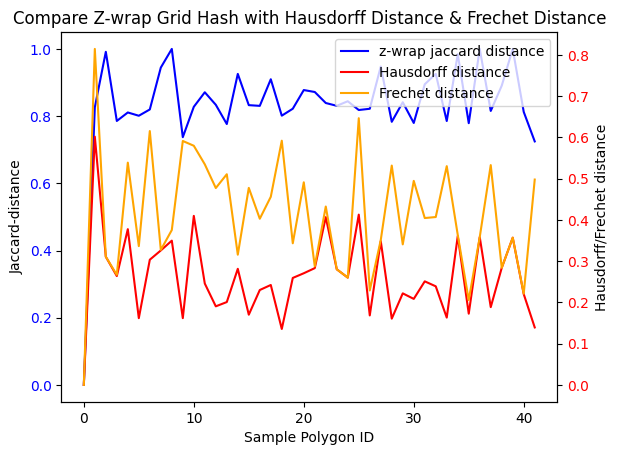

In [10]:
fig, axs = plt.subplots()

axs.set_title('Compare Z-wrap Grid Hash with Hausdorff Distance & Frechet Distance')
line1 = axs.plot(df['ZCURVEJD'], color='blue', label='z-wrap jaccard distance')
axs.tick_params(axis='y', labelcolor='blue')
axs.set_ylabel("Jaccard-distance")
axs2 = axs.twinx()
line2 = axs2.plot(df['hausdorff_distance'], color='red', label='Hausdorff distance')
line3 = axs2.plot(df['fretcher_distance'], color='orange', label='Frechet distance')
axs2.tick_params(axis='y', labelcolor='red')
axs2.set_ylabel("Hausdorff/Frechet distance")
axs.set_xlabel("Sample Polygon ID")
lines = line1 + line2 + line3
plt.legend(lines, [l.get_label() for l in lines],  loc='best')
plt.show()

In [16]:
df2 = pd.DataFrame({"Hash Type": ["line-by-line", "Z-wrap"]})
words = [4, 8, 16, 32]
scales = [50, 100, 200]
for scale in scales:
    interval = min_length / scale
    df3 = pd.DataFrame()
    for i in (range(len(df))):
        polygon = df.loc[i]['geometry']
        df3.loc[i, ['line']] = su.grid_to_string(polygon, interval, 1)
        df3.loc[i, ['z']] = su.grid_to_string(polygon, interval, 2)
    for word in words:
        df4 = pd.DataFrame()
        for i in (range(len(df))):
            df4.loc[i, ['line-jd']] = jaccard_distance(set(ngrams(df3.loc[0]['line'], word)), set(ngrams(df3.loc[i]['line'], word)))
            df4.loc[i, ['z-jd']] = jaccard_distance(set(ngrams(df3.loc[0]['z'], word)), set(ngrams(df3.loc[i]['z'], word)))
        df2.loc[0, ["scale=" + str(scale) + " shingle=" + str(word)]] = df4['line-jd'].corr(df['fretcher_distance'], method='pearson')
        df2.loc[1, ["scale=" + str(scale) + " shingle=" + str(word)]] = df4['z-jd'].corr(df['fretcher_distance'], method='pearson')
        
print(df2)

      Hash Type  scale=50 shingle=4  scale=50 shingle=8  scale=50 shingle=16  \
0  line-by-line            0.045386           -0.054749             0.105880   
1        Z-wrap           -0.135202            0.022331             0.247226   

   scale=50 shingle=32  scale=100 shingle=4  scale=100 shingle=8  \
0             0.400016            -0.068876             0.149700   
1             0.410363            -0.125825             0.015567   

   scale=100 shingle=16  scale=100 shingle=32  scale=200 shingle=4  \
0              0.209762              0.294362             0.090917   
1              0.221354              0.338240            -0.138752   

   scale=200 shingle=8  scale=200 shingle=16  scale=200 shingle=32  
0             0.125679              0.244270              0.267124  
1             0.029410              0.259126              0.299588  


In [17]:
# calculate multi resolution sketch hash varies by the disk size and number
multi_res_df = pd.DataFrame()
disk_number = [20, 40, 80, 160]
disk_radius = [min_length / 10, min_length / 15, min_length / 20, min_length / 40]
setting_df = pd.DataFrame({
    "disk_number": disk_number,
    "disk_radius": disk_radius
})
disk_collection = []
set_index = 0
for n in disk_number:
    row = []
    for r in disk_radius:
        disks = su.generate_multi_resolution_mask(df["geometry"], n, r)
        row.append(disks)
        multi_res_df[str(set_index)] = [""] * len(df)
        for i in range(len(df)):
            mr_hash = su.get_multi_resolution_hash(disks, df.iloc[i]['geometry'], r)
            multi_res_df.loc[i, [str(set_index)]] = mr_hash
        set_index += 1
    disk_collection.append(row)
multi_res_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,16161818,19191010,1919001461466141114611,6600330033,382422622423261923193838143314141410101037373810,112626323218518750700011,10103434383827272727,2222,3505329663785332506879687132797167677268156872...,2355705470344854341515487777268152781526275695...,1151115126722672686870497049414152152952152915...,2222510510003232134513134513131345452929,5128729714812436148153496112484361531526149106...,4128150636334683448684813113110843030108402002...,2071031022010275147595141139532113151321511115...,4545139139104104181868242468123123101331013339...
1,21124711749915181518,771516161518181010,00141466221919,1111,0016313111611721132117141314103727103537123030...,292937373636222121,222612261222223030118866393935353434,292922220088,1230585638341358812856383413555552521457632263...,7373242400217416217416565623172317656546644664...,6565117474797963636161766076603362336242425757...,272775232752324646545421214747131352523232,7778146771411467877122671136712211211058651491...,8383129106558798865510612962896626141861346289...,1401401104439661103911666116252511511811811511...,1213412134474710810883833358107581071111119733...
2,1616,,,66,3838,755518555187,3838,1313,507868783153250537232155372368,54542727,152952517151714141522915,,120743661366112074,645631253433445125,511311394040751495759514401315140139,1334844841013310
3,991116161818,55171719191010,221717551919131301406146,191910121210,2737351230271535122230341522342242622426182323...,341919112626212191091026260034,3303737017171010141411,99993434882222,4877213759213729945293131744597432797132797130...,1717222270707260724860482828737322412233417433...,6969181842674267262644656566766076606969,8843431414510510272747474545131350495049,9625356123311269112679540143983491123403412571...,1554239421553914659146935993113777711315915948...,9157576270707762773535921411419298152989898152...,1111116363212113713772727373686813513510038100...
4,18151877991115,18101017176618,1919441313881466142217175555,881919,2242622423192618192318368836368111713368111713...,2232321010003434191911,113535,151511,7140716786734248345245523366226652571463487748...,5826842684222233217433162174169917232317466446...,4949996613135361536176764848696969696767,005656121247474545131313134949661414,8483106841528652241381061155267861381221151462...,8111748131481813110841084715433626233141711415...,6434130641511511591241591231091241233021109932...,7373111051421051421571576666107107323298209820...


In [18]:
# calculate the correlation between jaccard distance from the first polygon to other polygon and the fretcher distance
multi_res_jaccard_df = pd.DataFrame()
corr_array = []
for c in range(16):
    multi_res_jaccard_df[str(c)] = [0] * len(df)
    for i in range(len(df)):
        if i != 0:
            try:
                multi_res_jaccard_df.loc[i, [str(c)]] = jaccard_distance(set(ngrams(multi_res_df.loc[0][str(c)], 3)), set(ngrams(multi_res_df.loc[i][str(c)], 3)))
            except:
                multi_res_jaccard_df.loc[i, [str(c)]] = 0
    corr_array.append(multi_res_jaccard_df[str(c)].corr(df['fretcher_distance'], method='pearson'))   

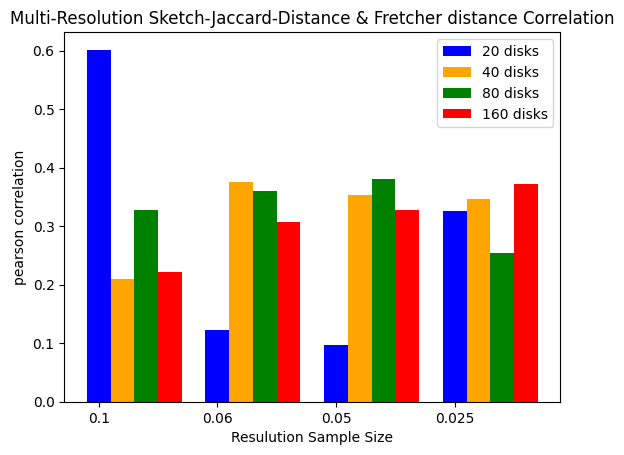

In [19]:
n_groups = 4
index = np.arange(n_groups)
bar_width = 0.2
fig, axs = plt.subplots()
plt.title("Multi-Resolution Sketch-Jaccard-Distance & Fretcher distance Correlation")
axs.set_ylabel("pearson correlation")
axs.bar(index, np.array(corr_array[0:4]), bar_width, label="20 disks", color="blue")
axs.bar(index+bar_width, np.array(corr_array[4:8]), bar_width, label="40 disks", color="orange")
axs.bar(index+bar_width*2, np.array(corr_array[8:12]), bar_width, label="80 disks", color="green")
axs.bar(index+bar_width*3, np.array(corr_array[12:16]), bar_width, label="160 disks", color="red")
axs.set_xticks(ticks=[0, 1, 2, 3], labels=["0.1", "0.06", "0.05", "0.025"])
axs.set_xlabel("Resulution Sample Size")
plt.legend(loc="best")
plt.show()

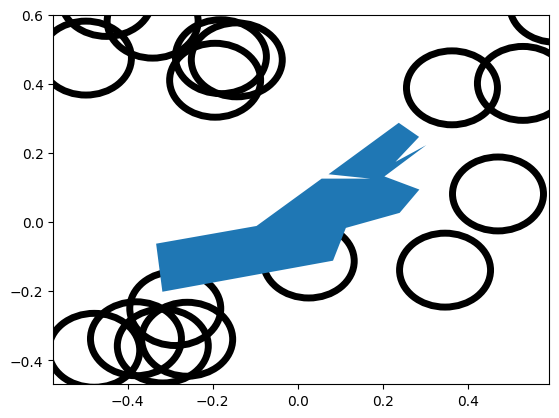

In [20]:
import matplotlib
plt.figure()
ax = plt.gca()
for disk in disk_collection[0][0]:
    circle = plt.Circle(disk.coords[0], min_length / 10, color='black', fill=False, lw=5)
    ax.add_artist(circle)

arr = []
for line in su.get_centralized_edge_from_polygon(df.iloc[0]["geometry"]):
    if len(arr) == 0:
        arr.append(line.coords[0])
    arr.append(line.coords[1])
    
collection = matplotlib.collections.PatchCollection([matplotlib.patches.Polygon(arr, fill=False, color="green")])
    
ax.add_artist(collection)
    
plt.xlim(canvas["x0"], canvas["x1"])
plt.ylim(canvas["y0"], canvas["y1"])
plt.show()

In [22]:
print("Jaccard Distance")
df4.head()

Jaccard Distance


,line-jd,z-jd
0,0.000000,0.000000
1,0.770089,0.854948
2,0.935647,0.884908
3,0.864304,0.842336
4,0.857784,0.820000


In [23]:
print("Hausdorff Distance & Frechet distance")
df[["hausdorff_distance", 'fretcher_distance']].head()

Hausdorff Distance & Frechet distance


,hausdorff_distance,fretcher_distance
0,0.000000,0.000000
1,0.601963,0.814756
2,0.310788,0.310789
3,0.263996,0.266962
4,0.377719,0.538974
